In [37]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import warnings
pd.set_option('display.max_columns', 500)

In [38]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Specify data locations

In [39]:
#Specify the path to clinical_data_cleaned.csv, which contains clinical features and outcome data
clinical_data_path = "D:\ISEN\M1\Projet M1\Survival_Rate_Prediction_DLBCL\CSV/clinical_data_KNN.csv"

#Specify the path to cell_shapes.csv, which contains geometric features for each tumor nucleus
features_path = "C:/Users/lucil/OneDrive/Documents/Big-Data/projet/KimiaNet/features.csv"
features_with_clinical_data_path = "D:\ISEN\M1\Projet M1\Survival_Rate_Prediction_DLBCL\CSV/features_with_clinical_data_1024_V3.csv"

# Select which features to use

In [40]:
#Specify one of the following: "ALL", "EXTRACTED", "CLINICAL"
FEATURES = "ALL"

In [41]:
if FEATURES == "ALL":
    data = features_with_clinical_data_path
elif FEATURES == "EXTRACTED":
    data = features_with_clinical_data_path
else:
    data = clinical_data_path

In [43]:
df_2 = pd.read_csv(clinical_data_path)
if FEATURES == "ALL":
    df = pd.read_csv(data)
    # df.drop(["weight"], inplace=True, axis=1)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS"], inplace=True, axis=1)
elif FEATURES == "EXTRACTED":
    df = pd.read_csv(data)
    # df["Unnamed: 0"] = df_2["patient_id"]
    # df = df.astype(np.float64)
    # df.set_index("Unnamed: 0", inplace=True)
    # df.index.set_names("patient_id", inplace=True)
    df.drop(["weight"], inplace=True, axis=1)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS", "MYC IHC", "BCL2 IHC", "BCL6 IHC", "CD10 IHC", "MUM1 IHC",
           "HANS", "BCL6 FISH", "MYC FISH", "BCL2 FISH", "Age", "ECOG PS", "LDH",
           "EN", "Stage", "IPI Score", "IPI Risk Group (4 Class)", "RIPI Risk Group"], inplace=True, axis=1)
else:
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS"], inplace=True, axis=1)
df.rename(columns={"Follow-up Status": "FUS"}, inplace=True)
df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,...,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.78,0.0,0.088093,0.037736,0.072670,0.004785,0.099546,0.255045,0.083281,0.150263,0.241883,0.027969,0.081558,0.022594,0.119703,0.092143,0.000000,0.000216,0.202344,1.022947,0.018109,0.316823,0.145919,0.056664,0.146886,0.101732,0.000000,0.012339,0.009823,0.223968,0.060601,0.190750,0.0,0.006755,0.491230,0.134432,0.738565,0.139892,0.001652,0.005734,0.055238,0.117088,0.005589,0.082005,0.127266,0.048763,0.080887,0.059692,0.036024,0.0,0.009634,0.126621,0.065364,0.0,0.048849,0.072853,0.226485,0.022872,0.311689,0.049483,0.070947,0.033477,0.034217,0.005595,0.022280,0.290725,0.023012,0.002100,0.064875,0.0,0.264879,0.358051,0.000315,0.122812,0.166075,0.000000,0.107746,0.002175,0.001691,0.0,0.037588,0.042308,0.159961,0.010067,0.200958,0.208882,0.402937,0.150299,0.0,0.189063,0.046558,1.389428,0.013086,0.619280,0.013231,0.013973,0.189278,0.0,0.000000,0.064453,1.300687,0.0,1.336252,0.074797,0.173977,0.246987,0.459042,0.004806,0.733700,0.001035,0.036308,0.000852,0.068517,0.097168,0.035119,0.0,0.099086,0.0,0.214465,0.0,0.116575,0.0,0.006765,0.0,0.000000,0.198460,0.0,0.023909,0.254417,1.258944,0.014116,0.160640,0.196989,0.588524,0.064112,0.111381,0.0,0.802961,0.0,0.011336,0.798834,1.109761,0.001843,0.033876,0.003285,1.908105,0.001588,0.036078,0.070532,0.269694,0.231560,0.034171,0.008478,0.113079,0.937154,0.077610,0.694597,0.053736,0.075270,0.0,0.267279,0.107589,0.0,0.235049,1.131417,0.044185,0.000000,0.

In [44]:
df.describe()

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,...,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.0,170.000000,170.000000,170.000000,170.0,170.000000,170.0,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.000000,170.000000,170.000000,170.0,170.000000,170.0,170.0,170.0

In [45]:
# Rename columns 0, 1, 2, ..., 1023 to "C0", "C1", "C2", ..., "C1023"
if FEATURES == "ALL":
    last_cols = ["C" + str(i) for i in range(df.shape[1]-19)]
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
elif FEATURES == "EXTRACTED":
    last_cols = ["C" + str(i) for i in range(df.shape[1]-2)]
    first_cols = ['OS', 'FUS']
else:
    last_cols = []
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
cols = first_cols + last_cols
df.columns = cols

In [46]:
# Drop all the columns with a variance of 0
final_df = df.loc[:, (df != df.iloc[0]).any()]
final_df


,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C87,C88,C89,C90,C91,C92,C93,C94,C96,C97,C98,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C114,C116,C117,C118,C120,C122,C123,C125,C126,C127,C128,C129,C130,C131,C132,C133,C135,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C161,C162,C163,C164,C166,C169,C170,C171,C172,C173,C176,C177,C178,C179,C180,C182,C183,C185,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C207,C208,C209,C210,C212,C213,C214,C215,C216,C217,C218,C219,C220,C221,C222,C223,C224,C225,C226,C227,C228,C230,C231,C232,C233,C234,C235,C236,C239,C241,C242,C243,C246,C247,C249,C250,C251,C252,C253,C254,C255,C256,C257,C258,C259,C260,C261,C262,...,C774,C775,C776,C777,C778,C779,C780,C781,C782,C783,C784,C785,C786,C787,C788,C789,C790,C791,C792,C793,C794,C795,C796,C797,C798,C799,C800,C801,C802,C803,C804,C805,C806,C807,C808,C809,C810,C811,C812,C813,C814,C815,C816,C817,C818,C819,C820,C821,C822,C823,C824,C825,C826,C827,C828,C829,C830,C831,C832,C833,C834,C835,C836,C837,C838,C839,C840,C841,C842,C843,C844,C845,C846,C847,C848,C849,C850,C851,C852,C853,C854,C855,C856,C857,C858,C859,C860,C861,C862,C863,C864,C865,C866,C867,C868,C869,C870,C871,C872,C873,C874,C875,C876,C877,C878,C879,C880,C881,C882,C883,C884,C885,C886,C887,C888,C889,C890,C891,C892,C893,C894,C895,C896,C897,C898,C899,C900,C901,C902,C903,C904,C905,C906,C907,C908,C909,C910,C911,C912,C913,C914,C915,C916,C917,C918,C919,C920,C921,C922,C923,C924,C925,C926,C927,C928,C929,C930,C931,C932,C933,C934,C935,C936,C937,C938,C939,C940,C941,C942,C943,C944,C945,C946,C947,C948,C949,C950,C951,C952,C953,C954,C955,C956,C957,C958,C959,C960,C961,C962,C963,C964,C965,C966,C967,C968,C969,C970,C971,C972,C973,C974,C975,C976,C977,C978,C979,C980,C981,C982,C983,C984,C985,C986,C987,C988,C989,C990,C991,C992,C993,C994,C995,C996,C997,C998,C999,C1000,C1001,C1002,C1003,C1004,C1005,C1006,C1007,C1008,C1009,C1010,C1011,C1012,C1013,C1014,C1015,C1016,C1017,C1018,C1019,C1020,C1021,C1022,C1023
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.78,0.0,0.088093,0.037736,0.072670,0.004785,0.099546,0.255045,0.083281,0.150263,0.241883,0.027969,0.081558,0.022594,0.119703,0.092143,0.000000,0.000216,0.202344,1.022947,0.018109,0.316823,0.145919,0.056664,0.146886,0.101732,0.000000,0.012339,0.009823,0.223968,0.060601,0.190750,0.006755,0.491230,0.134432,0.738565,0.139892,0.001652,0.005734,0.055238,0.117088,0.005589,0.082005,0.127266,0.048763,0.080887,0.059692,0.036024,0.009634,0.126621,0.065364,0.0,0.048849,0.072853,0.226485,0.022872,0.311689,0.049483,0.070947,0.033477,0.034217,0.005595,0.022280,0.290725,0.023012,0.002100,0.064875,0.264879,0.358051,0.000315,0.122812,0.166075,0.000000,0.107746,0.002175,0.001691,0.0,0.037588,0.042308,0.159961,0.010067,0.200958,0.208882,0.402937,0.150299,0.189063,0.046558,1.389428,0.013086,0.619280,0.013231,0.013973,0.189278,0.000000,0.064453,1.300687,1.336252,0.074797,0.173977,0.246987,0.459042,0.004806,0.733700,0.001035,0.

In [135]:
# Variance method to select the best features
NUMBER_OF_FEATURES = 37

new_df = df[last_cols]
std = []
for col in new_df.columns:
    std.append(df[col].std())
std = np.array(std)
std_top_n = np.argsort(std)[-NUMBER_OF_FEATURES:]

std_top_n_df = new_df.iloc[:, std_top_n]
# std_top_n_df

final_df = pd.concat([df[first_cols], std_top_n_df], axis=1)
final_df

,C820,C768,C883,C906,C1003,C885,C1007,C941,C1006,C887,C921,C865,C881,C837,C823,C1013,C892,C926,C915,C1019,C851,C791,C1011,C747,C896,C752,C751,C875,C944,C897,C927,C814,C949,C958,C994,C900,C1000
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,-7.929164,1.158364,-1.948991,-0.372414,-0.303171,4.939257,-1.938290,-0.453753,4.217590,-1.553118,-0.990606,-0.806259,4.651755,7.000115,5.900185,2.941210,2.565328,3.500647,4.296471,1.334263,-2.233671,1.114169,-0.142949,-0.189484,-2.042875,-0.051741,1.936634,6.555033,1.227377,4.512644,-2.927560,4.885540,-2.892566,-3.607765,5.093783,0.994537,-1.608368
13902.0,-3.790656,1.559190,-0.323290,-3.955793,-1.558855,2.391250,-1.129461,-6.348130,2.190337,-1.186619,-4.516446,-4.868114,1.330159,1.722482,1.853124,-0.925022,-0.735948,1.353122,4.360484,-0.723174,2.395299,-0.233852,-3.725114,-2.301294,-0.177048,2.125906,-2.577091,5.468253,-2.409188,2.264837,-1.929739,-0.434481,0.933187,-1.545147,1.490798,-0.819173,0.802426
13903.0,-4.943343,-2.078082,-1.917381,0.971848,-1.490713,3.524017,-1.547144,1.330803,3.675721,0.607472,-0.440896,1.708026,3.033710,5.916829,4.335407,3.233117,0.402539,4.988443,0.271005,1.488059,-4.641747,1.767105,-1.754567,-0.197819,1.901258,1.034761,1.105968,2.058663,4.414688,2.431251,0.716914,2.238345,-0.731346,-1.054255,4.312922,5.000374,-1.157169
13904.0,-7.195278,2.143269,-2.091459,0.756508,1.627265,3.500572,-1.840455,-0.675452,4.101389,-3.131798,-1.897923,-0.705350,4.261845,7.190701,4.126300,-0.013628,2.399463,4.237551,6.077055,2.365260,-1.090230,-2.154359,-0.812119,2.324432,-2.377026,-1.802920,1.844337,5.387630,0.499915,6.854267,-6.610900,3.145184,-2.152296,-3.257393,5.249294,0.542659,-2.827570
13905.0,-5.451605,4.273945,-2.322399,-1.616083,1.139225,4.143517,-3.511240,-2.541837,5.202374,-4.019173,-1.741958,-3.180482,5.029225,7.868685,3.171676,-2.018296,2.578021,3.667006,5.203305,1.480196,1.027833,-3.162818,-1.690671,2.291859,-2.608111,-1.989960,3.165348,6.020878,-1.559011,5.639592,-6.124520,0.933196,-1.767883,-4.246819,2.481623,0.082018,-2.042272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26853.0,-8.591806,0.638111,-3.091025,-0.212372,0.397541,5.004923,-1.777024,0.185345,4.067469,-1.467326,-0.479362,0.225950,4.440975,7.877778,7.131775,2.003775,1.660731,4.264771,3.792598,2.565448,-3.003164,0.911278,-0.778683,1.291893,-1.658359,-1.091460,3.108312,4.884712,1.864408,5.376666,-1.738878,5.090234,-3.878826,-3.263891,5.573689,3.117848,-1.959962
26857.0,-2.334310,-2.679958,-0.181415,-1.830726,-5.435679,0.894500,0.810944,0.123042,4.788253,3.713425,-4.538821,1.103589,1.006703,4.363883,5.350485,5.779681,-1.265741,0.667042,0.408595,-3.964489,-5.626322,2.618914,-2.350984,-3.859598,5.194298,4.032044,-2.624477,2.539625,5.720030,-2.291445,-0.280071,2.305730,2.548330,3.093613,1.217582,0.597188,3.570193
26858.0,-4.711203,0.868472,-2.933217,-2.134268,-0.182040,4.973953,-2.480981,-3.394038,4.723588,-1.985742,-1.965023,-1.206362,4.143931,4.380084,3.792588,0.016708,1.776916,3.257957,3.551733,1.097685,-0.966351,1.540771,-2.114022,0.956185,-2.518874,-1.756070,0.407576,4.640573,-1.173356,5.100973,-4.160644,-0.356677,-0.195545,-3.433631,3.815848,2.557896,-2.869354


In [47]:
# PCA method to select the best features
from sklearn.decomposition import PCA

NUMBER_OF_FEATURES = 128
new_df = df[last_cols]
# Perform PCA to reduce dimensionality
pca = PCA(n_components=NUMBER_OF_FEATURES)
pca.fit(new_df)
pca_transformed = pca.transform(new_df)
pca_df = pd.DataFrame(data=pca_transformed, columns=['PC{}'.format(i+1) for i in range(NUMBER_OF_FEATURES)])

final_df = np.hstack((df[first_cols], pca_df))
final_df= pd.DataFrame(final_df, columns=list(df[first_cols].columns) + list(pca_df.columns))
final_df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.78,0.0,-6.382415,2.140681,1.155161,-0.991515,-1.358548,-1.740273,0.706936,-2.029628,0.620412,-0.104031,0.820846,0.133175,-0.167722,0.509291,0.287629,0.064327,0.041382,0.738905,-0.294617,0.112489,-0.860731,0.011817,0.519474,0.502115,0.719590,0.157325,-0.096021,0.077403,-0.028084,-0.582523,0.190811,-0.487050,0.188396,0.593695,0.135643,0.213737,0.140588,0.011754,0.037593,-0.070285,0.171099,-0.198709,-0.220104,0.193243,-0.133893,-0.223526,0.127974,-0.018033,-0.094611,0.207318,0.213206,-0.248541,-0.133466,-0.110202,0.045800,-0.323680,0.036724,0.105970,-0.070200,0.168461,0.117262,-0.224586,-0.091285,0.325435,-0.016405,0.122043,-0.080051,-0.211600,-0.245576,-0.089973,-0.016060,-0.074975,0.060087,-0.223807,-0.157823,-0.045497,-0.227710,0.117586,0.001692,-0.156026,-0.260581,-0.014798,0.109062,-0.007116,-0.222486,0.088850,0.107674,-0.084850,0.090452,-0.168889,0.186839,0.315706,-0.071698,-0.077696,-0.029821,-0.018241,-0.046529,0.159203,0.068282,-0.277467,-0.009979,0.148305,-0.000516,0.063926,0.023905,-0.190682,-0.009012,0.040242,-0.022481,0.023814,0.029634,0.016090,-0.123095,-0.075934,-0.114167,0.036712,-0.127814,0.143316,0.053926,-0.197326,-0.050195,0.130352,0.167070,0.070238,-0.221653,-0.056352,0.020838,-0.014850
1,10.0,0.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,10.08,0.0,14.903593,3.795943,0.589155,-1.736217,-1.436007,-3.876050,-0.915118,-1.672839,1.942485,0.311142,-0.983145,-0.373468,-0.324778,0.277406,0.019500,0.875038,-0.340938,-0.529996,-0.554779,0.772100,0.245351,-0.074011,-0.197889,0.151725,0.003920,0.130713,-0.160962,0.163872,-0.287397,-0.749458,-0.079895,-0.287691,-0.116652,0.670665,0.359888,0.354704,0.510419,0.064988,0.345587,-0.228770,-0.664046,-0.340220,0.141520,-0.226309,-0.304651,-0.410863,-0.284108,0.273985,0.008292,0.066351,-0.101235,-0.310607,0.023397,-0.367428,0.561434,-0.097137,0.704020,0.055378,0.099859,-0.272429,0.266024,0.054293,0.259611,0.087645,0.206721,-0.494709,0.131931,0.079402,-0.382734,-0.171144,-0.173028,0.022331,-0.017070,0.451007,-0.294078,0.046341,-0.060343,0.177924,-0.049804,0.021386,0.054647,0.144490,-0.092353,-0.215233,-0.223668,-0.209819,-0.004848,0.040822,0.149182,0.249203,0.227273,-0.051918,0.184752,-0.335379,0.170940,0.109921,-0.118753,-0.028920,-0.021149,-0.284391,-0.055595,-0.239434,-0.057364,-0.037685,-0.162367,0.117963,-0.049751,-0.189087,0.008823,0.161398,0.169817,-0.148985,0.031309,0.187550,0.146406,-0.263035,-0.031890,0.057475,-0.256125,-0.026399,-0.006023,-0.054006,-0.199304,0.061512,-0.046121,-0.042881,-0.126328,0.011517
2,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,9.78,0.0,-12.170994,8.471639,5.509645,-0.277485,0.234625,4.017628,3.320252,-1.979901,-1.953404,4.147941,-1.585674,2.573195,-0.376955,-0.353927,2.161269,0.314953,-0.205392,-0.137785,-0.152951,0.883593,0.032606,0.863869,-0.795167,0.091717,-0.243061,-0.114822,-0.319826,-0.079223,0.047450,-0.378024,-0.308175,0.888027,-0.040809,0.155909,0.338857,-0.231564,0.387143,-0.370548,-0.082042,-0.754699,-0.313334,-0.518012,0.156821,-0.301245,-0.595854,-0.084847,0.289221,-0.416175,-0.393592,0.227022,0.139226,0.2132

In [ ]:
# ICA method to select the best features
from sklearn.decomposition import FastICA

NUMBER_OF_FEATURES = 59
new_df = df[last_cols]
# Apply ICA to reduce the number of features
ica = FastICA(n_components=NUMBER_OF_FEATURES)
ica.fit(new_df)
ica_transformed = ica.transform(new_df)
ica_df = pd.DataFrame(data=ica_transformed, columns=['IC{}'.format(i+1) for i in range(NUMBER_OF_FEATURES)])


final_df = np.hstack((df[first_cols], ica_df))
final_df= pd.DataFrame(final_df, columns=list(df[first_cols].columns) + list(ica_df.columns))
final_df


In [ ]:
# UMAP method to select the best features
import umap.umap_ as umap
#import umap  # depend de si python=3.9 ou pas
NUMBER_OF_FEATURES = 59
new_df = df[last_cols]
# Use UMAP to reduce the number of features
reducer = umap.UMAP(n_components=NUMBER_OF_FEATURES)
reducer.fit(new_df)
umap_transformed = reducer.transform(new_df)
umap_df = pd.DataFrame(data=umap_transformed, columns=['UMAP{}'.format(i+1) for i in range(NUMBER_OF_FEATURES)])

final_df = np.hstack((df[first_cols], umap_df))
final_df= pd.DataFrame(final_df, columns=list(df[first_cols].columns) + list(umap_df.columns))
final_df

In [ ]:
# IsoMap method to select the best features
from sklearn.manifold import Isomap

NUMBER_OF_FEATURES = 59
new_df = df[last_cols]
# Use Isomap to reduce the number of features
iso = Isomap(n_components=NUMBER_OF_FEATURES)
iso.fit(new_df)
iso_transformed = iso.transform(new_df)
iso_df = pd.DataFrame(data=umap_transformed, columns=['ISO{}'.format(i+1) for i in range(NUMBER_OF_FEATURES)])

final_df = np.hstack((df[first_cols], iso_df))
final_df= pd.DataFrame(final_df, columns=list(df[first_cols].columns) + list(iso_df.columns))
final_df

# Preprocess the data (quantile transformation)

In [48]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=10, random_state=42)
qt.fit(final_df)
final_df = pd.DataFrame.from_records(qt.transform(final_df), columns=final_df.columns)
final_df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
0,0.000000,0.437500,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.422222,0.888889,1.000000,0.611111,1.000000,0.944444,1.000000,1.000000,0.131229,0.0,0.292526,0.595373,0.652027,0.442786,0.409214,0.281016,0.649825,0.117648,0.690772,0.499444,0.724967,0.507799,0.441004,0.685541,0.576189,0.530450,0.515356,0.777654,0.341857,0.595049,0.112931,0.508844,0.781935,0.822739,0.883584,0.629214,0.426689,0.559957,0.431337,0.113189,0.657019,0.179313,0.671147,0.894935,0.622728,0.682752,0.645739,0.518582,0.529196,0.377044,0.712195,0.252609,0.250195,0.730286,0.320666,0.262431,0.656878,0.479134,0.416144,0.796617,0.774015,0.169038,0.288158,0.334706,0.578151,0.101617,0.551848,0.666158,0.376674,0.796668,0.702828,0.164528,0.301493,0.903036,0.451032,0.738530,0.301133,0.142875,0.102745,0.307324,0.490110,0.351839,0.642271,0.108190,0.188273,0.416174,0.099401,0.760214,0.540339,0.178637,0.080516,0.487993,0.772283,0.470048,0.104016,0.748527,0.783830,0.265944,0.777357,0.109411,0.897515,0.938779,0.264962,0.280235,0.429532,0.451090,0.331867,0.896280,0.741032,0.004730,0.504645,0.896824,0.501931,0.715246,0.573674,0.078881,0.490762,0.653916,0.443797,0.616025,0.642481,0.584021,0.120585,0.206445,0.110937,0.659645,0.098143,0.908371,0.750070,0.040628,0.265703,0.900457,0.943107,0.801909,0.012100,0.247095,0.639624,0.343871
1,0.611111,0.000000,0.888889,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.611111,0.000000,0.000000,0.000000,0.000000,0.784469,0.0,0.893275,0.653103,0.595271,0.331088,0.397926,0.106721,0.335113,0.173961,0.837707,0.601009,0.229257,0.354614,0.400788,0.593770,0.457130,0.838393,0.350175,0.295424,0.243972,0.829511,0.615081,0.444444,0.414198,0.671471,0.489227,0.614831,0.379294,0.628372,0.309932,0.096563,0.446647,0.286487,0.380158,0.906630,0.803996,0.813027,0.892457,0.573928,0.826578,0.232890,0.056694,0.117235,0.661409,0.262670,0.159077,0.107492,0.181781,0.825771,0.549881,0.625060,0.354845,0.109920,0.515492,0.103021,0.948533,0.357985,0.987397,0.570732,0.698242,0.130984,0.894347,0.580030,0.891781,0.672135,0.856176,0.024923,0.787982,0.654813,0.045362,0.172938,0.180323,0.554040,0.452996,1.000000,0.067616,0.604979,0.347106,0.891506,0.350842,0.566176,0.647983,0.851052,0.239692,0.094104,0.103356,0.088877,0.500143,0.624778,0.861200,0.926414,0.916331,0.340576,0.896820,0.000000,0.894553,0.818833,0.151386,0.407081,0.429311,0.000000,0.317424,0.029310,0.305582,0.363124,0.086900,0.883287,0.302143,0.064040,0.544979,0.904082,0.909640,0.087175,0.605816,0.936064,0.907758,0.000000,0.332894,0.774179,0.000000,0.334358,0.529196,0.231433,0.030111,0.784290,0.259558,0.292750,0.082712,0.583289
2,0.000000,0.519713,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.006536,0.000000,0.000000,0.611111,0.000000,0.000000,0.000000,0.000000,0.758751,0.0,0.012161,0.841754,0.821868,0.552451,0.618933,0.892515,0.897165,0.125497,0.172506,0.922203,0.131615,0.923860,0.387428,0.389366,0.910419,0.652842,0.406287,0.447194,0.407798,0.852051,0.514153,0.893592,0.108739,0.615434,0.310691,0.478845,0.263440,0.393348,0.499397,0.213640,0.270467,0.925974,0.434275,0.644908,0.792193,0.292531,0.829796,0.146433,0.414830,0.075899,0.181349,0.088817,0.68032

In [49]:
cph = CoxPHFitter(penalizer=0.01)
cph.fit(final_df, duration_col='OS', event_col='FUS', show_progress=True)
c_main = cph.score(final_df, scoring_method="concordance_index")
print("The C-index is: %.3f" % c_main)

Iteration 1: norm_delta = 6.13980, step_size = 0.9500, log_lik = -269.05995, newton_decrement = 164.52731, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.12423, step_size = 0.7125, log_lik = -194.10484, newton_decrement = 97.00698, seconds_since_start = 0.0
Iteration 3: norm_delta = 15.03602, step_size = 0.6412, log_lik = -204.16513, newton_decrement = 280.35752, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.39264, step_size = 0.1885, log_lik = -158.52730, newton_decrement = 45.08739, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.00275, step_size = 0.2217, log_lik = -142.51789, newton_decrement = 13.67428, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.36547, step_size = 0.3193, log_lik = -135.13802, newton_decrement = 7.33051, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.79355, step_size = 0.4597, log_lik = -129.95553, newton_decrement = 2.95373, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.43321, step_size = 0.6620, log_lik = -127.21286

<Axes: >

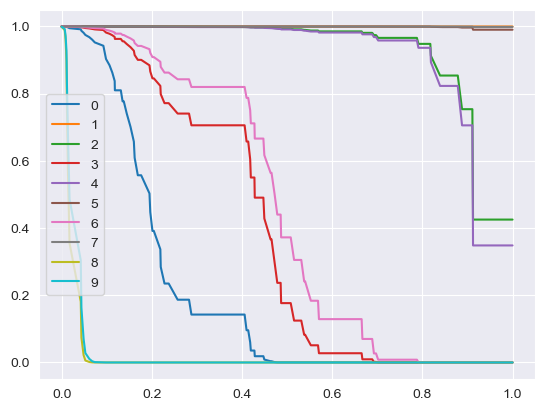

In [50]:
cph.predict_survival_function(final_df.iloc[0:10, :]).plot()

In [25]:
cph.print_summary()

## Optimism computation

In [51]:
np.random.seed(42)
c_b_boot, c_b_orig = [], []
num_bootstraps = 1000
bootstrap_size = len(final_df)

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]  #sample bootstrap replicate with replacement

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(new_df, duration_col='OS', event_col='FUS')  #fit on bootstrap

    c = cph.score(new_df, scoring_method="concordance_index")  #score on bootstrap
    c_b_boot.append(c)

    c = cph.score(final_df, scoring_method="concordance_index")  #score on original
    c_b_orig.append(c)

c_b_orig = np.array(c_b_orig)
c_b_boot = np.array(c_b_boot)

In [52]:
o = np.mean(c_b_boot - c_b_orig)
print("measure of optimism: %.3f" % o)

measure of optimism: 0.158


In [53]:
c_final = c_main - o
print("optimism-corrected c-index is %.3f" % c_final)

optimism-corrected c-index is 0.838


# 95% Confidence Intervals


In [54]:
# One-sided confidence interval
np.random.seed(42)
c_indices = []
num_bootstraps = 1000
bootstrap_size = len(final_df)

cph = CoxPHFitter(penalizer=0.01) #fit on original data
cph.fit(final_df, duration_col='OS', event_col='FUS')

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]

    c_index = cph.score(new_df, scoring_method="concordance_index")
    c_indices.append(c_index)

c_indices.sort()
hi = c_indices[974]
lo = c_indices[24]

print("One-sided confidence interval is: %.3f - %.3f" % (lo, hi))

One-sided confidence interval is: 0.992 - 0.999


In [55]:
# Two-sided confidence interval
np.random.seed(42)
c_indices = []
num_bootstraps = 1000
bootstrap_size = len(final_df)

cph = CoxPHFitter(penalizer=0.01) #fit on original data
cph.fit(final_df, duration_col='OS', event_col='FUS')

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]

    c_index = cph.score(new_df, scoring_method="concordance_index")
    c_indices.append(c_index)

c_indices.sort()
#o = cph.score(final_df, scoring_method="concordance_index") #calculate original C-index

# calculate adjusted confidence interval using t-test and error bounds
mean = np.mean(c_indices)
std_err = np.std(c_indices, ddof=1) / np.sqrt(num_bootstraps)
t_value = 1.96
lower_bound = mean - t_value * std_err
upper_bound = mean + t_value * std_err
print("Two-sided confidence interval is: %.3f - %.3f" % (lower_bound, upper_bound))


Two-sided confidence interval is: 0.996 - 0.996


In [56]:
print("Adjusting for optimism")
print("Adjusted one-sided confidence interval is: %.3f - %.3f" % (lo-o, hi-o))
print("Adjusted two-sided confidence interval is: %.3f - %.3f" % (lower_bound-o, upper_bound-o))

Adjusting for optimism
Adjusted one-sided confidence interval is: 0.834 - 0.841
Adjusted two-sided confidence interval is: 0.838 - 0.838
